<a href="https://colab.research.google.com/github/anuragkumar95/Projects/blob/master/pos_tagging_using_glove_vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from nltk.corpus import treebank
import string
#import nltk
#nltk.download('all')

## Glove Vectors:

I am using glove vector representation of words for pos taggging. To download the vectors follow the below steps :
  

1.   
```
Download the glove vectors using !wget http://nlp.stanford.edu/data/glove.6B.zip
```


2.   
```
Unzip it using !unzip glove*.zip
```


3.   
```
The files are stored in "/content/file_having_vectors.txt" in google colab. Use this path to access the vectors.
```






In [0]:

embeds = {}
words = []
f = open('/content/glove.6B.100d.txt', encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:], dtype='float32')
    embeds[word] = vectors
    words.append(word)
f.close()

words = set(words)

Let's check the number of dictinct words available in Glove

In [29]:
len(words)

400000

I load the entire penntreebank corpus from nltk. Ofcourse, this data contains words whose vector represetation is not available in Glove. I simply remove such words so that I can represent each of the remaining words using Glove. 

I tokenize each word, change each word to its lowercase and squash it in 1D array. 

In [0]:
#Loading penntreebank corpus from nltk

sentences = treebank.tagged_sents(tagset='universal')

data = sum([[s[0].strip().lower() for s in word if s[0].strip().lower() in words] for word in sentences],[])
data_labels = sum([[s[1].strip().lower() for s in word if s[0].strip().lower() in words] for word in sentences],[])

tags = set(data_labels)

Checking the vocab size after above preprocessing

In [7]:
(len(data),len(tags))

94815

I concatenate glove word embeddings of w[i-2], w[]i-1],w[i],w[i+1], w[i+2] for every word w[i]. I am using the 100d glove representation. thus, our input has the size (vocab_size, 500). 

In [0]:
def vectors(data,labels,embeddings):
  vectors = []
  for i in range(2, len(data)-2):
    if data[i] in embeddings.keys():
      vectors.append(np.concatenate((embeddings[data[i-2]],
                                    embeddings[data[i-1]],
                                    embeddings[data[i]],
                                    embeddings[data[i+1]],
                                    embeddings[data[i+2]])))
  return vectors 

In [0]:
#one hot encodding of the labels
def one_hot(labels,tag_list):
  coding = {tag:i for tag,i in zip(tag_list,range(len(tag_list)))}
  one_hot = []
  for tag in labels:
    temp = [0 for i in tag_list]
    temp[coding[tag]] = 1
    one_hot.append(temp)
  return one_hot

I keep 60,000 samples for training, 10000 samples for validation and the rest for testing. 

In [0]:
train = vectors(data[:60000], data_labels[:60000], embeds)
val = vectors(data[60000:70000], data_labels[60000:70000], embeds)
test = vectors(data[70000:], data_labels[70000:], embeds)

train_labels = one_hot(data_labels[:60000], tags)[2:-2]
val_labels = one_hot(data_labels[60000:70000], tags)[2:-2]
test_labels = one_hot(data_labels[70000:], tags)[2:-2]

The below graph for one layer feed forward neural network has input of shape (500, ) and output of shape (12, ).

In [0]:
input_dim = len(train[0])
hidden_dim = 1024
output_dim = len(tags)
lr = 0.001
n_epoche = 10000
batch_size = 1250
alpha = 0

#Loading inputs and outputs
x = tf.placeholder(tf.float32, [None, input_dim])
y = tf.placeholder(tf.float32, [None, output_dim])


#Weights and biases
W = {'h1':tf.Variable(tf.random_normal([input_dim,hidden_dim])),
     'out':tf.Variable(tf.random_normal([hidden_dim,output_dim]))
    }

b = {'b1':tf.Variable(tf.random_normal([hidden_dim])),
     'b_out':tf.Variable(tf.random_normal([output_dim]))
    }

#forward pass
z2 = tf.add(tf.matmul(x,W['h1']),b['b1'])
a2 = tf.nn.tanh(z2)
z3 = tf.add(tf.matmul(a2,W['out']),b['b_out'])
y_pred = tf.nn.tanh(z3)


#cost
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y,\
                                                              logits = y_pred))

#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(cost)

#prediction and accuracy 
pred = tf.equal(tf.argmax(y_pred,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(pred,tf.float32))


Now that our graph is ready, let's run it! The training happens over 10k iterations.

In [0]:
#initializing
saver = tf.train.Saver()
hist = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
init = tf.initialize_all_variables()
print("Starting computation....")
sess = tf.Session()

sess.run(init)
for epoches in range(n_epoche):
  for epoche in range(len(train)//batch_size):
    offset = (epoche * batch_size) % (len(train_labels) - batch_size)
    batch_x = train[offset:(offset+batch_size)]
    batch_y = train_labels[offset:(offset+batch_size)]

    o,c = sess.run([optimizer,cost],\
                              feed_dict = {x:batch_x, y:batch_y})
   
  train_acc = sess.run(accuracy, feed_dict = {x:train, y:train_labels})
  if epoches % 1 == 0 or epoches == 0:
    val_loss, val_pred = sess.run([cost,pred],\
                                  feed_dict = {x:val,y:val_labels})
    val_acc = sess.run(accuracy, feed_dict = {x:val,y:val_labels})
    message = "epoche {:0d} : train_loss = {:02.02f}, train_acc = {:02.4f}, val_loss = {:02.02f}, val_acc = {:02.04f}".format(epoches, c, train_acc, val_loss, val_acc)
    test_acc = sess.run(accuracy, feed_dict = {x:test, y:test_labels})
    print(message)
  hist['train_acc'].append(train_acc)
  hist['train_loss'].append(c)
  hist['val_acc'].append(val_acc)
  hist['val_loss'].append(val_loss)
  #Saving model
  saved_path = saver.save(sess, '/content/gdrive/My Drive/my-model.ckpt', global_step=epoche)
  if epoches == n_epoche-1: 
    print("Training done!")
    print("Test_Accuracy:",test_acc)

Saving the weights and biases of this model. They are stored in '/content/gdrive/My Drive/filename' path. We can mount the google drive, access this path to read in the hyper-parameters.




In [0]:
import pickle
W_in = sess.run(W['h1'])
W_out = sess.run(W['out'])
b_in = sess.run(b['b1'])
b_out = sess.run(b['b_out'])

weights = {'W1':W_in, 'W2': W_out}
biases = {'b1':b_in, 'b2': b_out}

from google.colab import drive
drive.mount('/content/gdrive')
f = open('/content/gdrive/My Drive/weights.pickle', 'wb')
pickle.dump(weights,f)
f.close()

f = open('/content/gdrive/My Drive/biases.pickle', 'wb')
pickle.dump(biases,f)
f.close()

f = open('/content/gdrive/My Drive/history.pickle', 'wb')
pickle.dump(hist,f)
f.close()

Evaluating on test dataset it gives an accuracy of ~92%. The training dataset had 60,000 samples to train on. In the research paper “Part-of-Speech Tagging with Neural Networks” by Helmud Schmid, they claim to get a very similar performance for a dataset of size 60,000.I believe this model well generalizes over unseen data as this model never saw the test dataset.

In [35]:
train_acc = sess.run(accuracy, feed_dict = {x:train, y:train_labels})
val_acc = sess.run(accuracy, feed_dict = {x:val, y:val_labels})
test_acc = sess.run(accuracy, feed_dict = {x:test, y:test_labels})

print("Train_Accuracy:",train_acc)
print("Validation_Accuracy:",val_acc)
print("Test_Accuracy:",test_acc)

Train_Accuracy: 0.98783255
Validation_Accuracy: 0.907463
Test_Accuracy: 0.91995484


Plotting train and validation accuracy vs interations

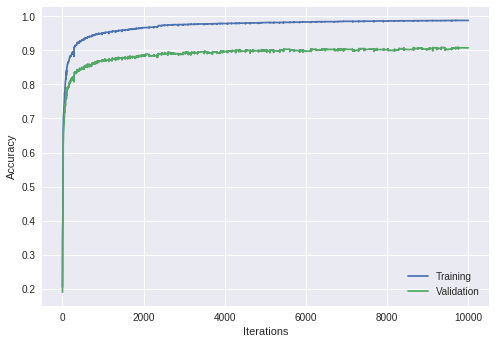

In [32]:
plt.plot(hist['train_acc'])
plt.plot(hist['val_acc'])
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

Plotting train and validation loss vs iterations

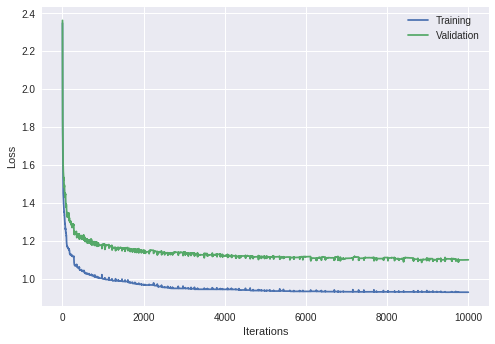

In [33]:
plt.plot(hist['train_loss'])
plt.plot(hist['val_loss'])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

This performance was achieved by using a simple feed forward network with just one hidden layer. Judging from the plots I can say this model did not overfit and well generalizes over unseen data. I have attached a the weights abd baises pickle files with this submission.